# Shailja Somani, John Vincent Deniega, Muris Saab
# ADS 508 - Team 2
# Spring 2024

## Set-Up

### Initialize Packages & SageMaker variables
Reference: Coyne, S. (2024, February 27). Update 01_Copy_TSV_To_S3.ipynb [Jupyter Notebook]. GitHub. Retrieved March 15, 2024, from https://github.com/MADS508/labs/blob/main/04_ingest/01_Copy_TSV_To_S3.ipynb.

In [57]:
import boto3
import sagemaker
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Import PyAthena

Coyne, S. (2022, October 9). 02_Create_Athena_Database.ipynb [Jupyter Notebook]. GitHub. Retrieved March 15, 2024, from https://github.com/MADS508/labs/commits/main/04_ingest/02_Create_Athena_Database.ipynb.

In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Create & Verify Athena Database

Coyne, S. (2022, October 9). 02_Create_Athena_Database.ipynb [Jupyter Notebook]. GitHub. Retrieved March 15, 2024, from https://github.com/MADS508/labs/commits/main/04_ingest/02_Create_Athena_Database.ipynb.

In [24]:
database_name = "covid"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS covid


""


In [25]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,covid
1,default
2,dsoaws


## Copy 5 CSVs from Public S3 Bucket into My Private Bucket

In [67]:
# Check what is in public S3 bucket for our team
s3_public_path_csv = "s3://ads508-team2-spring24/"
!aws s3 ls $s3_public_path_csv

2024-03-16 23:56:13     592336 01_MD_COVID-19_-_Cases_by_ZIP_Code.csv
2024-03-17 22:02:37   61876919 02_SDOH_2020_ZIPCODE_1_0.csv
2024-03-16 23:56:16    3660534 03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv
2024-03-17 22:09:43     164479 04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv
2024-03-17 22:02:39    2564885 05_ZIPCodetoZCTACrosswalk2022UDS.csv


In [57]:
# Copy each file from the Public S3 bucket to its own folder in my private S3 bucket 
# We keep them all in their own folders because Athena external table creation takes in a full S3 folder name, not a file name

# Maryland covid cases file - list path names to file in public & where to copy in private
s3_public_path_md_covid = "s3://ads508-team2-spring24/01_MD_COVID-19_-_Cases_by_ZIP_Code.csv"
s3_priv_path_md_covid = "s3://{}/ads508-team2-spring24/md_covid_cases/01_MD_COVID-19_-_Cases_by_ZIP_Code.csv".format(bucket)

# Actually copy over
!aws s3 cp $s3_public_path_md_covid $s3_priv_path_md_covid

copy: s3://ads508-team2-spring24/01_MD_COVID-19_-_Cases_by_ZIP_Code.csv to s3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/md_covid_cases/01_MD_COVID-19_-_Cases_by_ZIP_Code.csv


In [58]:
# Check that copied properly 
!aws s3 ls $s3_priv_path_md_covid

2024-03-17 21:50:06     592336 01_MD_COVID-19_-_Cases_by_ZIP_Code.csv


In [64]:
# SDOH file - list path names to file in public & where to copy in private
s3_public_path_sdoh = "s3://ads508-team2-spring24/02_SDOH_2020_ZIPCODE_1_0.csv"
s3_priv_path_sdoh = "s3://{}/ads508-team2-spring24/sdoh_2020_data/02_SDOH_2020_ZIPCODE_1_0.csv".format(bucket)

# Actually copy over
!aws s3 cp $s3_public_path_sdoh $s3_priv_path_sdoh

# Check that copied properly 
!aws s3 ls $s3_priv_path_sdoh

copy: s3://ads508-team2-spring24/02_SDOH_2020_ZIPCODE_1_0.csv to s3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/sdoh_2020_data/02_SDOH_2020_ZIPCODE_1_0.csv
2024-03-17 22:05:35   61876919 02_SDOH_2020_ZIPCODE_1_0.csv


In [65]:
# CDC PLACES data file - list path names to file in public & where to copy in private
s3_public_path_cdc = "s3://ads508-team2-spring24/03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv"
s3_priv_path_cdc = "s3://{}/ads508-team2-spring24/cdc_places_data/03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv".format(bucket)

# Actually copy over
!aws s3 cp $s3_public_path_cdc $s3_priv_path_cdc

# Check that copied properly 
!aws s3 ls $s3_priv_path_cdc

copy: s3://ads508-team2-spring24/03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv to s3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/cdc_places_data/03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv
2024-03-17 22:06:21    3660534 03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv


In [68]:
# MD Census data file - list path names to file in public & where to copy in private
s3_public_path_md_census = "s3://ads508-team2-spring24/04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv"
s3_priv_path_md_census = "s3://{}/ads508-team2-spring24/md_census_data/04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv".format(bucket)

# Actually copy over
!aws s3 cp $s3_public_path_md_census $s3_priv_path_md_census

# Check that copied properly 
!aws s3 ls $s3_priv_path_md_census

copy: s3://ads508-team2-spring24/04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv to s3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/md_census_data/04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv
2024-03-17 22:10:09     164479 04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv


In [69]:
# Zip Code to ZTCA Crosswalk data file - list path names to file in public & where to copy in private
s3_public_path_xwalk = "s3://ads508-team2-spring24/05_ZIPCodetoZCTACrosswalk2022UDS.csv"
s3_priv_path_xwalk = "s3://{}/ads508-team2-spring24/crosswalk_data/05_ZIPCodetoZCTACrosswalk2022UDS.csv".format(bucket)

# Actually copy over
!aws s3 cp $s3_public_path_xwalk $s3_priv_path_xwalk

# Check that copied properly 
!aws s3 ls $s3_priv_path_xwalk

copy: s3://ads508-team2-spring24/05_ZIPCodetoZCTACrosswalk2022UDS.csv to s3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/crosswalk_data/05_ZIPCodetoZCTACrosswalk2022UDS.csv
2024-03-17 22:11:13    2564885 05_ZIPCodetoZCTACrosswalk2022UDS.csv


In [83]:
# Check that everything is now in my private bucket
s3_priv_bucket = "s3://{}/ads508-team2-spring24/".format(bucket)
!aws s3 ls $s3_priv_bucket

                           PRE cdc_places_data/
                           PRE crosswalk_data/
                           PRE md_census_data/
                           PRE md_covid_cases/
                           PRE sdoh_2020_data/
2024-03-17 21:28:56     592336 01_MD_COVID-19_-_Cases_by_ZIP_Code.csv
2024-03-17 21:28:56   61503879 02_SDOH_2020_ZIPCODE_1_0.xlsx
2024-03-17 21:28:56    3660534 03_PLACES__Local_Data_for_Better_Health__ZCTA_Data_2023_release.csv
2024-03-17 22:09:01     164479 04_Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas.csv
2024-03-17 21:28:56    1512369 05_ZIPCodetoZCTACrosswalk2022UDS.xlsx


## Create Athena Tables/Parquet Tables from S3 CSV Files

Coyne, S. (2022, October 9). 03_Register_S3_TSV_With_Athena.ipynb [Jupyter Notebook]. GitHub. Retrieved March 15, 2024, from https://github.com/MADS508/labs/blob/main/04_ingest/03_Register_S3_TSV_With_Athena.ipynb. \
Coyne, S. (2022, October 9). 04_Convert_S3_TSV_To_Parquet_With_Athena.ipynb [Jupyter Notebook]. GitHub. Retrieved March 17, 2024, from https://github.com/MADS508/labs/blob/main/04_ingest/04_Convert_S3_TSV_To_Parquet_With_Athena.ipynb.

In [26]:
# Set S3 path to parquet data
s3_path_parquet = "s3://{}/ads508-team2-spring24/parquet/".format(bucket)

In [71]:
# Create string variables to hold names for respective tables and the database for SQL statement
MDCovid_table = "MDCovid"
SDOH_table = "SDOH"
CDC_table = "CDC"
MDCensus_table = "MDCensus"
MDCrosswalk_table = "MDCrosswalk"

# Database name
database_name = "covid"

# Parquet names
CDC_parquet = "CDC_parquet"
SDOH_parquet = "SDOH_parquet"

### Tables that don't have meaningful partitions, thus don't need to be parquets for our purposes

#### MD Covid by Zip Code Table 

In [38]:
# Build SQL statement to create MD Covid by Zip Code Athena Table
table_name = MDCovid_table
path = "s3://{}/ads508-team2-spring24/md_covid_cases/".format(bucket)

'''
NOTE: The covid counts in this table are running totals, not just new cases.
However, as stated in our Assignment 2.1, to avoid the additional confounding variable of time, we will just train 
     & test our model on one week of data at a time. Thus, it's not important how the numbers for each time point are 
     calculated, as long as it remains consistent for that time point. 
There is data for every day in 2022, but we don't want to explode our this table that much, so we'll just push the 
    first 10 days of the year.
'''
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID int,
         ZIP_CODE int,
         total01_01_2022 int,
         total01_02_2022 int,
         total01_03_2022 int,
         total01_04_2022 int,
         total01_05_2022 int,
         total01_06_2022 int,
         total01_07_2022 int,
         total01_08_2022 int,
         total01_09_2022 int,
         total01_10_2022 int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.MDCovid(
         OBJECTID int,
         ZIP_CODE int,
         total01_01_2022 int,
         total01_02_2022 int,
         total01_03_2022 int,
         total01_04_2022 int,
         total01_05_2022 int,
         total01_06_2022 int,
         total01_07_2022 int,
         total01_08_2022 int,
         total01_09_2022 int,
         total01_10_2022 int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/md_covid_cases/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [39]:
# Actually create table (execute statement)
pd.read_sql(statement, conn)

""


In [33]:
# Check that worked
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,mdcovid


In [37]:
# Test that data is stored properly
pd.read_sql("SELECT * FROM covid.MDCovid LIMIT 10", conn).head(10)

,objectid,zip_code,total01_01_2022,total01_02_2022,total01_03_2022,total01_04_2022,total01_05_2022,total01_06_2022,total01_07_2022,total01_08_2022,total01_09_2022,total01_10_2022
0,517,20010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,518,20015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,519,20037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,520,20074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,521,20161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,522,20185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,523,20437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,525,20602,3755.0,3834.0,3941.0,4014.0,4055.0,4105.0,4140.0,4214.0,4292.0,4323.0
8,526,20603,3851.0,3946.0,4049.0,4127.0,4185.0,4277.0,4328.0,4441.0,4555.0,4609.0
9,527,20604,55.0,56.0,57.0,59.0,60.0,61.0,61.0,61.0,63.0,64.0


#### Maryland Census Data Table

In [56]:
table_name = MDCensus_table
path = "s3://{}/ads508-team2-spring24/md_census_data/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         OBJECTID_1 int,
         ZCTA5CE10 int,
         FIRST_STAT int,
         FIRST_GEOI int,
         FIRST_CLAS CHAR(2),
         FIRST_MTFC string,
         FIRST_FUNC CHAR(1),
         ZCTA5N int,
         STATE int,
         AREALAND int,
         AREAWATR int,
         POP100 int,
         HU100 int,
         NHW int,
         NHB int,
         NHAI int,
         NHA int,
         NHNH int,
         NHO int,
         NHT int,
         HISP int,
         PNHW DECIMAL(3,1),
         PNHB DECIMAL(3,1),
         PNHAI DECIMAL(2,1),
         PNHA DECIMAL(2,1),
         PNHNH DECIMAL(2,1),
         PNHO DECIMAL(2,1),
         PNHT DECIMAL(2,1),
         PHISP DECIMAL(2,1),
         POP65_ int,
         PCTPOP65_ DECIMAL(3,1),
         MEDAGE DECIMAL(3,1)
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.MDCensus(
         OBJECTID_1 int,
         ZCTA5CE10 int,
         FIRST_STAT int,
         FIRST_GEOI int,
         FIRST_CLAS CHAR(2),
         FIRST_MTFC string,
         FIRST_FUNC CHAR(1),
         ZCTA5N int,
         STATE int,
         AREALAND int,
         AREAWATR int,
         POP100 int,
         HU100 int,
         NHW int,
         NHB int,
         NHAI int,
         NHA int,
         NHNH int,
         NHO int,
         NHT int,
         HISP int,
         PNHW DECIMAL(3,1),
         PNHB DECIMAL(3,1),
         PNHAI DECIMAL(2,1),
         PNHA DECIMAL(2,1),
         PNHNH DECIMAL(2,1),
         PNHO DECIMAL(2,1),
         PNHT DECIMAL(2,1),
         PHISP DECIMAL(2,1),
         POP65_ int,
         PCTPOP65_ DECIMAL(3,1),
         MEDAGE DECIMAL(3,1)
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/md_census_data/'
TBLPROPERTIES ('sk

In [57]:
# Actually run query
pd.read_sql(statement, conn)

""


In [58]:
# Take a look at table to test 
df_show = pd.read_sql("SELECT * FROM covid.MDCensus LIMIT 5", conn)
df_show.head()

,objectid_1,zcta5ce10,first_stat,first_geoi,first_clas,first_mtfc,first_func,zcta5n,state,arealand,...,pnhb,pnhai,pnha,pnhnh,pnho,pnht,phisp,pop65_,pctpop65_,medage
0,1,20601,24,2420601,B5,G6350,S,20601,24,115635266,...,46.1,0.6,3.6,0.0,0.2,3.5,5.3,1922,8.0,37.3
1,2,20602,24,2420602,B5,G6350,S,20602,24,35830723,...,52.3,0.5,2.9,0.1,0.2,4.0,6.1,1964,7.9,32.6
2,3,20603,24,2420603,B5,G6350,S,20603,24,44239637,...,51.9,0.3,5.0,0.1,0.2,3.8,5.5,1400,4.8,34.5
3,4,20606,24,2420606,B5,G6350,S,20606,24,7501011,...,10.4,0.2,0.9,0.0,0.0,0.0,0.9,108,25.1,49.1
4,5,20607,24,2420607,B5,G6350,S,20607,24,54357590,...,64.5,0.3,5.7,0.0,0.1,2.4,4.9,847,8.6,40.9


#### ZTCA to Zip Code Crosswalk Table

In [62]:
table_name = MDCrosswalk_table
path = "s3://{}/ads508-team2-spring24/crosswalk_data/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         ZIP_CODE int,
         PO_NAME string,
         STATE CHAR(2),
         ZIP_TYPE string,
         zcta int,
         zip_join_type string
)ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.MDCrosswalk(
         ZIP_CODE int,
         PO_NAME string,
         STATE CHAR(2),
         ZIP_TYPE string,
         zcta int,
         zip_join_type string
)ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/crosswalk_data/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [63]:
# Actually run query
pd.read_sql(statement, conn)

# Take a look at table to test 
df_show = pd.read_sql("SELECT * FROM covid.MDCrosswalk LIMIT 5", conn)
df_show.head()

,zip_code,po_name,state,zip_type,zcta,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,601,Adjuntas,PR,Zip Code Area,601,Zip matches ZCTA
3,602,Aguada,PR,Zip Code Area,602,Zip matches ZCTA
4,603,Aguadilla,PR,Zip Code Area,603,Zip matches ZCTA


### Tables that have Meaningful Partitions, Thus should be Parquets

#### PLACES: Local Data for Better Health Table & then Parquet Table

In [68]:
table_name = CDC_table
path = "s3://{}/ads508-team2-spring24/cdc_places_data/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         YEAR int,
         LocationName int,
         DataSource string,
         Category string,
         Measure string,
         Data_Value_Unit string,
         Data_Value_Type string,
         Data_Value DECIMAL(3,1),
         Data_Value_Footnote_Symbol string,
         Data_Value_Footnote string,
         Low_Confidence_Limit DECIMAL(3,1),
         High_Confidence_Limit DECIMAL(3,1),
         TotalPopulation int,
         Geolocation string,
         LocationID int,
         CategoryID string,
         MeasureId string,
         DataValueTypeID string,
         Short_Question_Text string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.CDC(
         YEAR int,
         LocationName int,
         DataSource string,
         Category string,
         Measure string,
         Data_Value_Unit string,
         Data_Value_Type string,
         Data_Value DECIMAL(3,1),
         Data_Value_Footnote_Symbol string,
         Data_Value_Footnote string,
         Low_Confidence_Limit DECIMAL(3,1),
         High_Confidence_Limit DECIMAL(3,1),
         TotalPopulation int,
         Geolocation string,
         LocationID int,
         CategoryID string,
         MeasureId string,
         DataValueTypeID string,
         Short_Question_Text string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/cdc_places_data/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [70]:
# Actually run query
pd.read_sql(statement, conn)

# Take a look at table to test 
df_show = pd.read_sql("SELECT * FROM covid.CDC LIMIT 5", conn)
df_show.head()

,year,locationname,datasource,category,measure,data_value_unit,data_value_type,data_value,data_value_footnote_symbol,data_value_footnote,low_confidence_limit,high_confidence_limit,totalpopulation,geolocation,locationid,categoryid,measureid,datavaluetypeid,short_question_text
0,2021,20601,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,7.5,,,6.4,8.6,24156,POINT (-76.85084002 38.61369741),20601,PREVENT,ACCESS2,CrdPrv,Health Insurance
1,2021,20601,BRFSS,Health Outcomes,Arthritis among adults aged >=18 years,%,Crude prevalence,22.8,,,20.3,25.4,24156,POINT (-76.85084002 38.61369741),20601,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis
2,2021,20601,BRFSS,Health Risk Behaviors,Binge drinking among adults aged >=18 years,%,Crude prevalence,16.9,,,14.3,19.6,24156,POINT (-76.85084002 38.61369741),20601,RISKBEH,BINGE,CrdPrv,Binge Drinking
3,2021,20601,BRFSS,Health Outcomes,High blood pressure among adults aged >=18 years,%,Crude prevalence,36.2,,,33.0,39.3,24156,POINT (-76.85084002 38.61369741),20601,HLTHOUT,BPHIGH,CrdPrv,High Blood Pressure
4,2021,20601,BRFSS,Prevention,Taking medicine for high blood pressure contro...,%,Crude prevalence,75.4,,,72.2,78.4,24156,POINT (-76.85084002 38.61369741),20601,PREVENT,BPMED,CrdPrv,Taking BP Medication


In [78]:
# Build parquet with partitions for CDC data
table_name_parquet = CDC_parquet
table_name_csv = CDC_table
# SQL statement to execute - select only tables desired 
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['category']) AS
SELECT year, locationname, measure, data_value_unit, data_value, low_confidence_limit, high_confidence_limit, locationid, category
FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_csv
)

print(statement)

CREATE TABLE IF NOT EXISTS covid.CDC_parquet
WITH (format = 'PARQUET', external_location = 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/parquet/', partitioned_by = ARRAY['category']) AS
SELECT year, locationname, measure, data_value_unit, data_value, low_confidence_limit, high_confidence_limit, locationid, category
FROM covid.CDC


In [79]:
# Execute SQL statement to build parquet
pd.read_sql(statement, conn)

,rows


In [80]:
# Test that worked
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_name_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,category=Health Risk Behaviors
1,category=Health Status
2,category=Health Outcomes
3,category=Prevention
4,category=Disability


#### Social Determinants of Health Database Table & then Parquet Table

##### Use Pandas to select only certain columns & create new S3 location for that subset
This dataset has 327 columns, so I want to select only certain ones before pushing to Athena

In [84]:
s3 = s3fs.S3FileSystem(anon=False)
original_file_path = 'ads508-team2-spring24/sdoh_2020_data/02_SDOH_2020_ZIPCODE_1_0.csv'
new_file_path = 'ads508-team2-spring24/sdoh_2020_data_limited/02_limited_SDOH_2020_ZIPCODE_1_0.csv'

# Use s3fs to handle S3 path with pd
with s3.open(f's3://{bucket}/{original_file_path}', 'rb') as f:
    df = pd.read_csv(f)

In [108]:
# limit to desired columns
desired_columns = ['YEAR', 'STATEFIPS', 'ZIPCODE', 'ZCTA', 'STATE', 'ACS_PCT_WHITE_ZC', 'ACS_GINI_INDEX_ZC', 'ACS_MEDIAN_HH_INC_ZC', 
                  'ACS_PCT_AGE_ABOVE65_ZC', 'ACS_PCT_DISABLE_ZC', 'ACS_PCT_EMPLOYED_ZC', 'ACS_PCT_ENGLISH_ZC', 'ACS_PCT_FEMALE_ZC', 
                   'ACS_PCT_HH_INTERNET_ZC', 'ACS_PCT_HS_GRADUATE_ZC', 'ACS_PCT_HU_NO_VEH_ZC', 'ACS_PCT_MEDICARE_ONLY_ZC', 
                   'ACS_PCT_SPANISH_ZC', 'ACS_PCT_UNINSURED_ZC', 'ACS_PCT_VET_ZC'] 
df_reduced = df[desired_columns]

In [102]:
# Write the reduced DataFrame back to S3
with s3.open(f's3://{bucket}/{new_file_path}', 'w') as f:
    df_reduced.to_csv(f, index=False)

##### Actually create table & parquet table

In [105]:
table_name = SDOH_table
path = "s3://{}/ads508-team2-spring24/sdoh_2020_data_limited/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         YEAR int,
         STATEFIPS int,
         ZIPCODE int,
         ZCTA int,
         STATE string,
         ACS_PCT_WHITE_ZC DECIMAL (4,2),
         ACS_GINI_INDEX_ZC DECIMAL (3,2),
         ACS_MEDIAN_HH_INC_ZC DECIMAL (7,2),
         ACS_PCT_AGE_ABOVE65_ZC DECIMAL (4,2),
         ACS_PCT_DISABLE_ZC DECIMAL (4,2),
         ACS_PCT_EMPLOYED_ZC DECIMAL (4,2),
         ACS_PCT_ENGLISH_ZC DECIMAL (4,2),
         ACS_PCT_FEMALE_ZC DECIMAL (4,2),
         ACS_PCT_HH_INTERNET_ZC	DECIMAL (4,2),
         ACS_PCT_HS_GRADUATE_ZC	DECIMAL (4,2),
         ACS_PCT_HU_NO_VEH_ZC DECIMAL (4,2),
         ACS_PCT_MEDICARE_ONLY_ZC DECIMAL (4,2),
         ACS_PCT_SPANISH_ZC DECIMAL (4,2),
         ACS_PCT_UNINSURED_ZC DECIMAL (4,2),
         ACS_PCT_VET_ZC DECIMAL (4,2)
)ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.SDOH(
         YEAR int,
         STATEFIPS int,
         ZIPCODE int,
         ZCTA int,
         STATE string,
         ACS_PCT_WHITE_ZC DECIMAL (4,2),
         ACS_GINI_INDEX_ZC DECIMAL (3,2),
         ACS_MEDIAN_HH_INC_ZC DECIMAL (7,2),
         ACS_PCT_AGE_ABOVE65_ZC DECIMAL (4,2),
         ACS_PCT_DISABLE_ZC DECIMAL (4,2),
         ACS_PCT_EMPLOYED_ZC DECIMAL (4,2),
         ACS_PCT_ENGLISH_ZC DECIMAL (4,2),
         ACS_PCT_FEMALE_ZC DECIMAL (4,2),
         ACS_PCT_HH_INTERNET_ZC	DECIMAL (4,2),
         ACS_PCT_HS_GRADUATE_ZC	DECIMAL (4,2),
         ACS_PCT_HU_NO_VEH_ZC DECIMAL (4,2),
         ACS_PCT_MEDICARE_ONLY_ZC DECIMAL (4,2),
         ACS_PCT_SPANISH_ZC DECIMAL (4,2),
         ACS_PCT_UNINSURED_ZC DECIMAL (4,2),
         ACS_PCT_VET_ZC DECIMAL (4,2)
)ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/sdoh_2020_data_limited/'
TBLPROPERTIES ('s

In [107]:
# Actually run query
pd.read_sql(statement, conn)

# Take a look at table to test 
df_show = pd.read_sql("SELECT * FROM covid.SDOH LIMIT 50", conn)
df_show.head(50)

,year,statefips,zipcode,zcta,state,acs_pct_white_zc,acs_gini_index_zc,acs_median_hh_inc_zc,acs_pct_age_above65_zc,acs_pct_disable_zc,acs_pct_employed_zc,acs_pct_english_zc,acs_pct_female_zc,acs_pct_hh_internet_zc,acs_pct_hs_graduate_zc,acs_pct_hu_no_veh_zc,acs_pct_medicare_only_zc,acs_pct_spanish_zc,acs_pct_uninsured_zc,acs_pct_vet_zc
0,2020,15,96759,NaN,Hawaii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,2,99675,NaN,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,41,97010,NaN,Oregon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,6,93928,NaN,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,6,95836,NaN,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020,15,96784,NaN,Hawaii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020,2,99666,NaN,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020,2,99764,NaN,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020,2,99841,NaN,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020,32,89033,NaN,Nevada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Build parquet with partitions for SDOH data
table_name_parquet = SDOH_parquet
table_name_csv = SDOH_table
# SQL statement to execute - select only tables desired 
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['state']) AS
SELECT year, statefips, zipcode, zcta, acs_pct_white_zc, acs_gini_index_zc, acs_median_hh_inc_zc, acs_pct_age_above65_zc, acs_pct_disable_zc,
    acs_pct_employed_zc, acs_pct_english_zc, acs_pct_female_zc, acs_pct_hh_internet_zc, acs_pct_hs_graduate_zc, acs_pct_hu_no_veh_zc, 
    acs_pct_medicare_only_zc, acs_pct_spanish_zc, acs_pct_uninsured_zc, acs_pct_vet_zc, state
FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_csv
)

print(statement)

CREATE TABLE IF NOT EXISTS covid.SDOH_parquet
WITH (format = 'PARQUET', external_location = 's3://sagemaker-us-east-1-590183834230/ads508-team2-spring24/parquet/', partitioned_by = ARRAY['state']) AS
SELECT year, statefips, zipcode, zcta, acs_pct_white_zc, acs_gini_index_zc, acs_median_hh_inc_zc, acs_pct_age_above65_zc, acs_pct_disable_zc,
    acs_pct_employed_zc, acs_pct_english_zc, acs_pct_female_zc, acs_pct_hh_internet_zc, acs_pct_hs_graduate_zc, acs_pct_hu_no_veh_zc, 
    acs_pct_medicare_only_zc, acs_pct_spanish_zc, acs_pct_uninsured_zc, acs_pct_vet_zc, state
FROM covid.SDOH


In [112]:
# Execute SQL statement to build parquet
pd.read_sql(statement, conn)

# Test that worked
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_name_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,state=Indiana
1,state=Oregon
2,state=New Jersey
3,state=Maine
4,state=Massachusetts


### Check all tables are in Covid database

In [82]:
statement = "SHOW TABLES FROM covid"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,tab_name
0,cdc
1,cdc_parquet
2,mdcensus
3,mdcovid
4,mdcrosswalk
5,sdoh
6,sdoh_parquet


## Prep Features for Modeling

### Pivot CDC PLACES data so that there is 1 row per zip code

In [9]:
# Read in from Athena table
cdc_df = pd.read_sql("SELECT * FROM covid.cdc", conn)
cdc_df.head()

,year,locationname,datasource,category,measure,data_value_unit,data_value_type,data_value,data_value_footnote_symbol,data_value_footnote,low_confidence_limit,high_confidence_limit,totalpopulation,geolocation,locationid,categoryid,measureid,datavaluetypeid,short_question_text
0,2021,20601,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,7.5,,,6.4,8.6,24156.0,POINT (-76.85084002 38.61369741),20601,PREVENT,ACCESS2,CrdPrv,Health Insurance
1,2021,20601,BRFSS,Health Outcomes,Arthritis among adults aged >=18 years,%,Crude prevalence,22.8,,,20.3,25.4,24156.0,POINT (-76.85084002 38.61369741),20601,HLTHOUT,ARTHRITIS,CrdPrv,Arthritis
2,2021,20601,BRFSS,Health Risk Behaviors,Binge drinking among adults aged >=18 years,%,Crude prevalence,16.9,,,14.3,19.6,24156.0,POINT (-76.85084002 38.61369741),20601,RISKBEH,BINGE,CrdPrv,Binge Drinking
3,2021,20601,BRFSS,Health Outcomes,High blood pressure among adults aged >=18 years,%,Crude prevalence,36.2,,,33.0,39.3,24156.0,POINT (-76.85084002 38.61369741),20601,HLTHOUT,BPHIGH,CrdPrv,High Blood Pressure
4,2021,20601,BRFSS,Prevention,Taking medicine for high blood pressure contro...,%,Crude prevalence,75.4,,,72.2,78.4,24156.0,POINT (-76.85084002 38.61369741),20601,PREVENT,BPMED,CrdPrv,Taking BP Medication


In [10]:
# Check to see if any duplicates 
duplicates = cdc_df.duplicated(subset=['locationname', 'short_question_text'], keep=False)
cdc_df[duplicates].head()

,year,locationname,datasource,category,measure,data_value_unit,data_value_type,data_value,data_value_footnote_symbol,data_value_footnote,low_confidence_limit,high_confidence_limit,totalpopulation,geolocation,locationid,categoryid,measureid,datavaluetypeid,short_question_text


In [17]:
# Pivot data so that each row is a ZCTA (geographical location) and each column is a metric 
pivoted_cdc = cdc_df.pivot_table(index='locationname', 
                                columns='short_question_text', 
                                values='data_value',
                                aggfunc='first') 

# Make locationname a column again & remove short_question_text as header
pivoted_cdc.reset_index(inplace=True)
pivoted_cdc.columns.name = None
pivoted_cdc.head()

,locationname,All Teeth Lost,Annual Checkup,Any Disability,Arthritis,Binge Drinking,COPD,Cancer (except skin),Cervical Cancer Screening,Cholesterol Screening,...,Mental Health,Mobility Disability,Obesity,Physical Health,Physical Inactivity,Self-care Disability,Sleep <7 hours,Stroke,Taking BP Medication,Vision Disability
0,20601,9.8,78.8,20.6,22.8,16.9,4.9,5.3,87.9,88.8,...,14.4,9.9,41.9,9.2,20.7,2.9,39.5,2.6,75.4,3.9
1,20602,12.5,78.7,22.7,22.4,16.6,5.3,5.0,86.8,87.1,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
2,20603,9.2,78.8,18.7,20.3,17.3,4.1,4.5,88.6,88.9,...,14.3,8.7,41.9,8.3,19.2,2.7,40.0,2.2,73.3,3.6
3,20606,15.5,77.1,31.9,35.8,13.0,9.2,9.1,82.0,88.7,...,15.6,17.6,38.0,12.6,28.0,4.4,35.9,4.4,81.1,5.7
4,20607,7.4,74.5,20.1,23.0,12.5,4.1,5.6,86.2,90.9,...,12.3,10.1,39.0,8.2,19.9,3.0,39.5,2.8,77.1,3.9


### Load in & Filter MD Covid Cases data to target column

In [32]:
# Read in from Athena table - select only zip code & the values for 1/10 (our target column)
md_covid_df = pd.read_sql("SELECT zip_code, total01_10_2022 FROM covid.mdcovid", conn)

# Filter to cases that are not null or 0, which are unreliable
md_covid_df = md_covid_df[(md_covid_df['total01_10_2022'].notnull()) & (md_covid_df['total01_10_2022'] != 0)]
md_covid_df.reset_index(inplace=True)
md_covid_df.drop(columns=['index'], inplace=True)

# Check how many rows are left 
md_covid_df.shape

(468, 2)

In [33]:
md_covid_df.head()

,zip_code,total01_10_2022
0,20602,4323.0
1,20603,4609.0
2,20604,64.0
3,20606,33.0
4,20607,1844.0


### Join all tables to build feature set

#### Load in necessary cols from other 3 datasets

In [34]:
# Read in MD Census data from Athena table - select ZCTA, land area, population, & median age columns
md_census_df = pd.read_sql("SELECT zcta5ce10, arealand, pop100, medage FROM covid.mdcensus", conn)
md_census_df.head()

,zcta5ce10,arealand,pop100,medage
0,20601,115635266,24156,37.3
1,20602,35830723,24955,32.6
2,20603,44239637,28967,34.5
3,20606,7501011,431,49.1
4,20607,54357590,9802,40.9


In [35]:
# Read in SDOH data from Athena table 
sdoh_df = pd.read_sql("""SELECT zipcode, acs_pct_white_zc, acs_gini_index_zc, acs_median_hh_inc_zc, acs_pct_age_above65_zc, acs_pct_disable_zc,
                acs_pct_employed_zc, acs_pct_english_zc, acs_pct_female_zc, acs_pct_hh_internet_zc, acs_pct_hs_graduate_zc, acs_pct_hu_no_veh_zc, 
                acs_pct_medicare_only_zc, acs_pct_spanish_zc, acs_pct_uninsured_zc, acs_pct_vet_zc FROM covid.sdoh_parquet
                WHERE state = 'Maryland'""", conn)
sdoh_df.head()

,zipcode,acs_pct_white_zc,acs_gini_index_zc,acs_median_hh_inc_zc,acs_pct_age_above65_zc,acs_pct_disable_zc,acs_pct_employed_zc,acs_pct_english_zc,acs_pct_female_zc,acs_pct_hh_internet_zc,acs_pct_hs_graduate_zc,acs_pct_hu_no_veh_zc,acs_pct_medicare_only_zc,acs_pct_spanish_zc,acs_pct_uninsured_zc,acs_pct_vet_zc
0,20601,33.58,0.37,NaN,11.99,9.06,95.39,91.25,51.77,94.19,29.69,0.58,1.82,4.90,2.91,14.38
1,20604,27.32,0.36,88794.0,11.03,11.56,94.27,91.16,55.61,88.90,34.02,6.34,1.96,3.98,3.95,11.75
2,20602,27.32,0.36,88794.0,11.03,11.56,94.27,91.16,55.61,88.90,34.02,6.34,1.96,3.98,3.95,11.75
3,20603,26.36,0.36,NaN,7.35,5.90,96.54,86.12,51.31,92.21,23.14,1.88,1.22,6.25,3.82,15.43
4,20606,84.08,0.26,NaN,32.80,21.02,NaN,NaN,42.36,88.15,55.42,0.00,11.15,0.00,0.00,6.16


In [36]:
# Read in zip code to ZCTA crosswalk from Athena table
xwalk_df = pd.read_sql("SELECT zip_code, zcta FROM covid.mdcrosswalk WHERE state='MD'", conn)
xwalk_df.head()

,zip_code,zcta
0,20058,20817
1,20207,20814
2,20233,20746
3,20389,20746
4,20395,20746


#### Join all data

In [40]:
# Join MD covid data to crosswalk & make sure there's a mapped value for each row for ZCTA - should be 0 nulls
md_covid_zcta = pd.merge(md_covid_df, xwalk_df, on='zip_code', how='left')
md_covid_zcta['zcta'].isnull().sum()

0

In [46]:
# Join to all other features
all_data = pd.merge(md_covid_zcta, md_census_df, left_on='zcta', right_on='zcta5ce10', how='left')
all_data = pd.merge(all_data, sdoh_df, left_on='zip_code', right_on='zipcode', how='left')
all_data = pd.merge(all_data, pivoted_cdc, left_on='zcta', right_on='locationname', how='left')

# Drop extraneous join columns
all_data.drop(columns=['zcta', 'zcta5ce10', 'zipcode', 'locationname'], inplace=True)

# Set zipcode as index as it's not a feature
all_data.set_index('zip_code', inplace=True)

# Check df
all_data.head()

,total01_10_2022,arealand,pop100,medage,acs_pct_white_zc,acs_gini_index_zc,acs_median_hh_inc_zc,acs_pct_age_above65_zc,acs_pct_disable_zc,acs_pct_employed_zc,...,Mental Health,Mobility Disability,Obesity,Physical Health,Physical Inactivity,Self-care Disability,Sleep <7 hours,Stroke,Taking BP Medication,Vision Disability
zip_code,,,,,,,,,,,,,,,,,,,,,
20602,4323.0,35830723.0,24955.0,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
20603,4609.0,44239637.0,28967.0,34.5,26.36,0.36,NaN,7.35,5.90,96.54,...,14.3,8.7,41.9,8.3,19.2,2.7,40.0,2.2,73.3,3.6
20604,64.0,35830723.0,24955.0,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
20606,33.0,7501011.0,431.0,49.1,84.08,0.26,NaN,32.80,21.02,NaN,...,15.6,17.6,38.0,12.6,28.0,4.4,35.9,4.4,81.1,5.7
20607,1844.0,54357590.0,9802.0,40.9,22.78,0.30,NaN,12.62,10.08,92.40,...,12.3,10.1,39.0,8.2,19.9,3.0,39.5,2.8,77.1,3.9


In [47]:
# Check that still have 468 rows that initially started with from MD Covid data
all_data.shape

(468, 53)

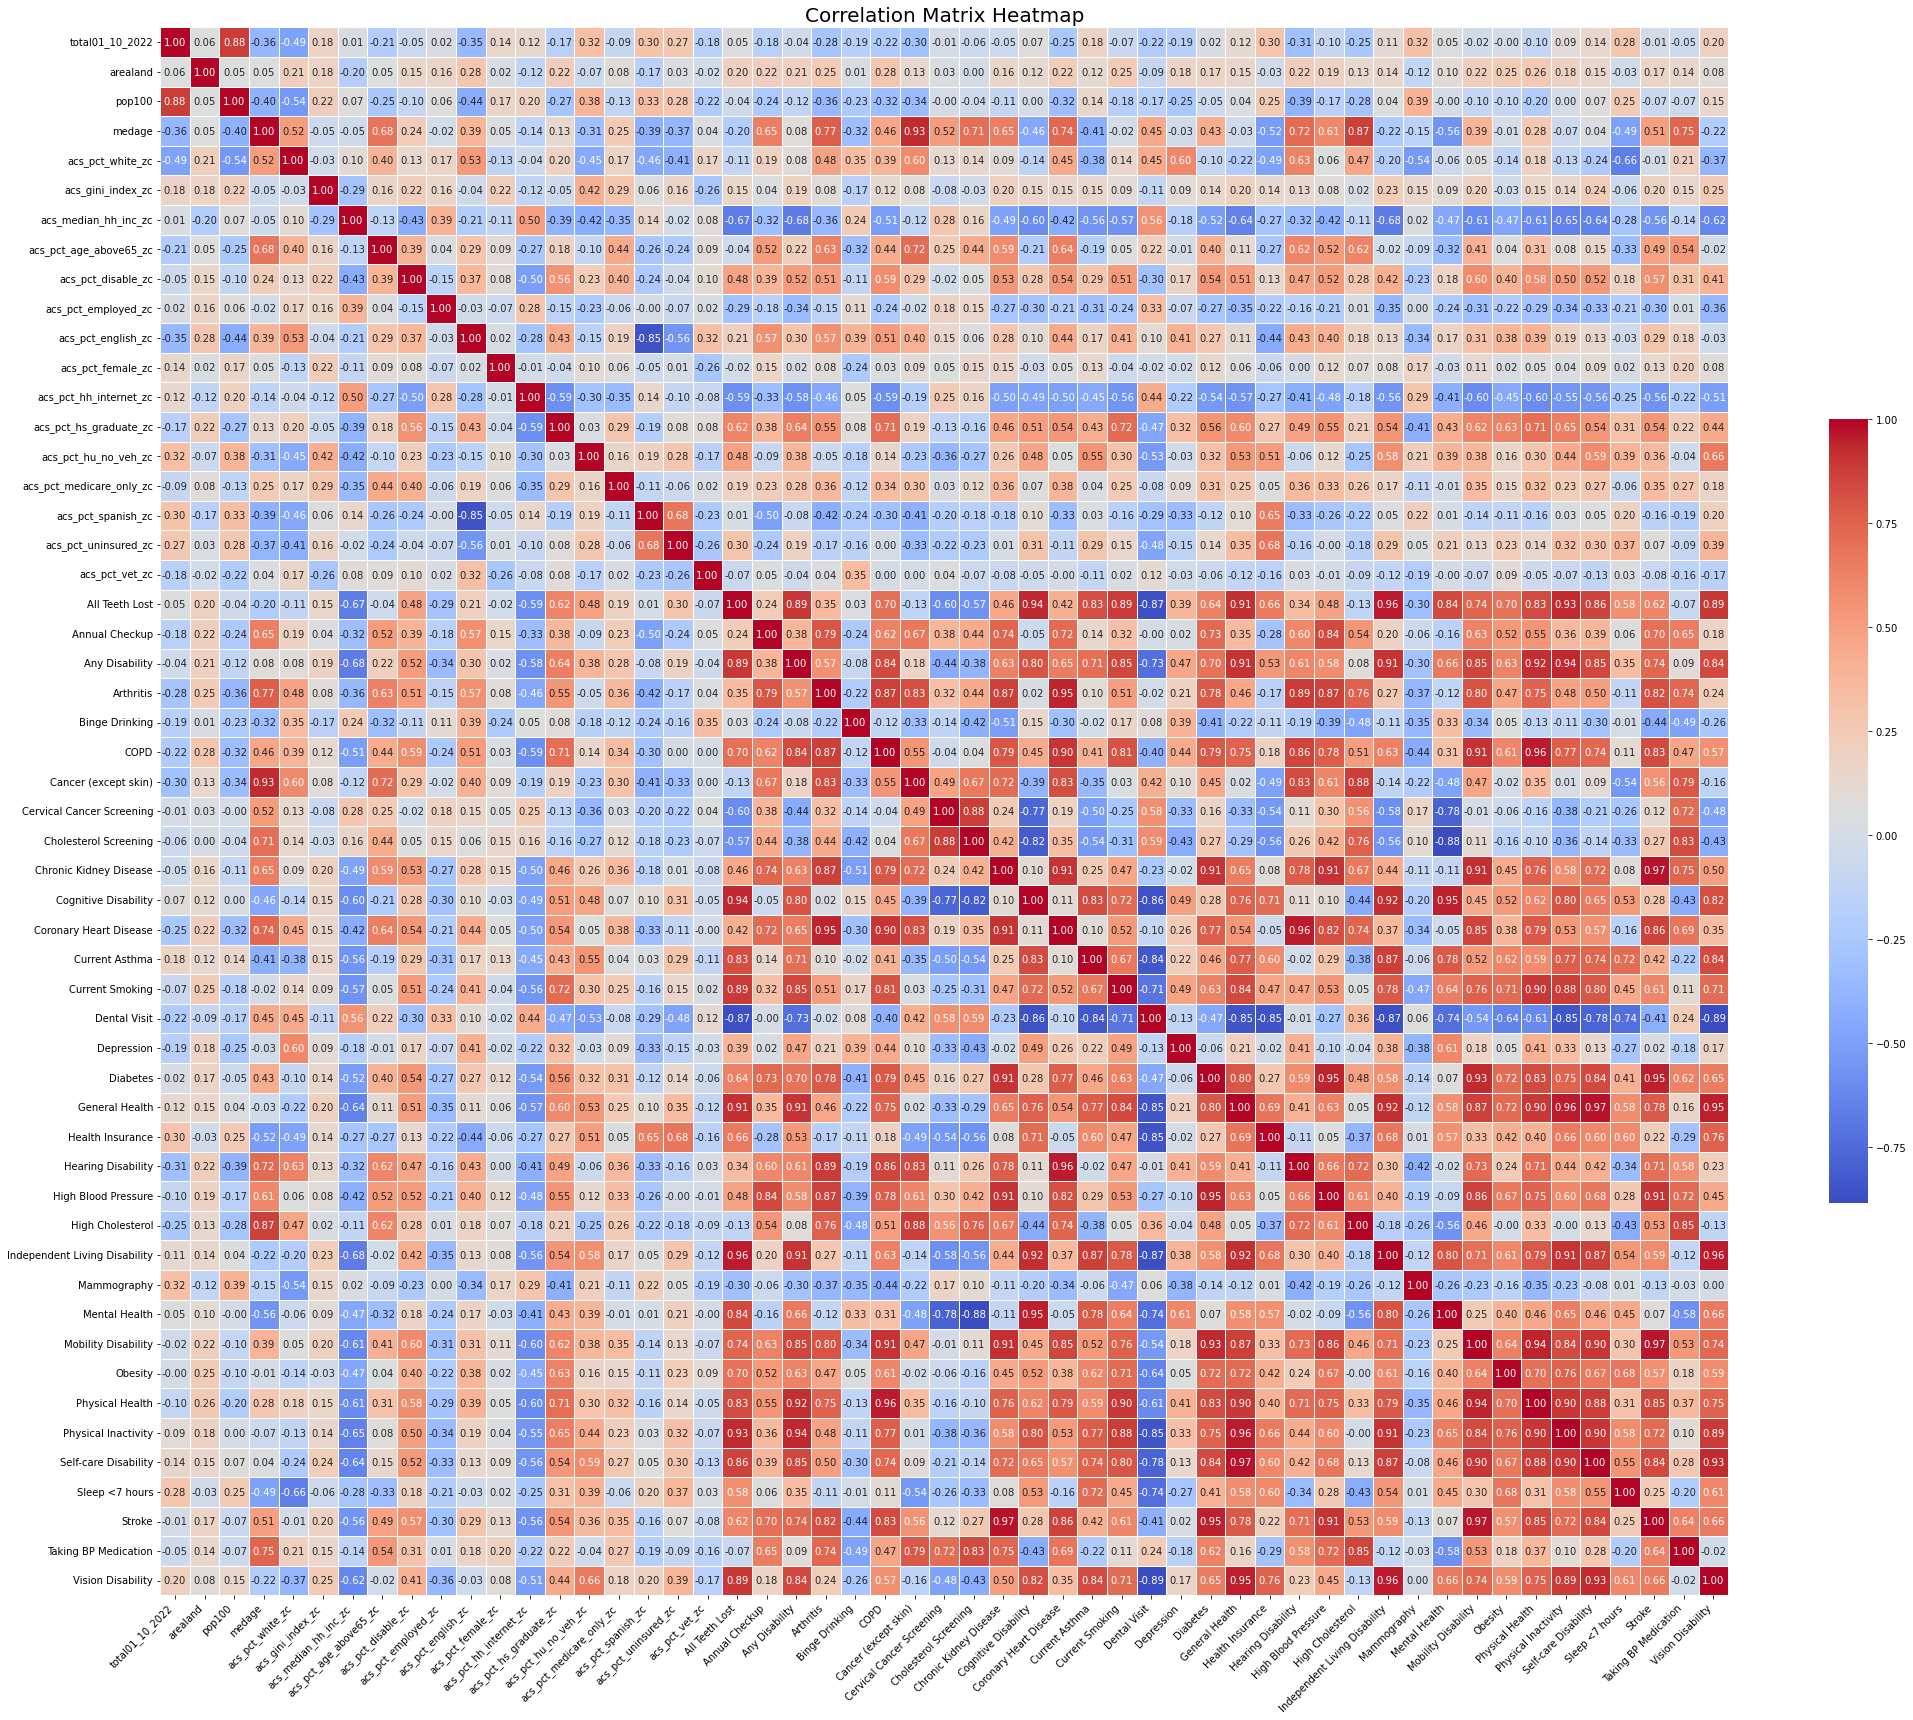

In [63]:
# Get correlation plot for data
# Calculate the correlation matrix
corr = all_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30, 24))

# Generate a heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

# Adjust layout to make room for the rotated x-axis labels
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.tight_layout()  

# Show the plot
plt.show()

### Save all combined data into Athena

In [68]:
# Replace all spaces in column names with underscores for ease of querying
all_data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [88]:
# Remove special characters as well
all_data.rename(columns={'Cancer_(except_skin)': 'Cancer_except_skin',
                   'Sleep_<7_hours': 'Sleep_less_than_7hrs',
                   'Self-care_Disability': 'Self_care_Disability'}, inplace=True)

In [89]:
# Write to S3 location first
all_data_file_path = 'ads508-team2-spring24/all_data_combined/full_features_and_target.csv'
s3 = s3fs.S3FileSystem(anon=False)

# Save all_date to file path specified
with s3.open(f's3://{bucket}/{all_data_file_path}', 'w') as f:
    all_data.to_csv(f, index=False)

In [90]:
# Check that saved correctly
with s3.open(f's3://{bucket}/{all_data_file_path}', 'rb') as f:
    df = pd.read_csv(f)
df.head()

,total01_10_2022,arealand,pop100,medage,acs_pct_white_zc,acs_gini_index_zc,acs_median_hh_inc_zc,acs_pct_age_above65_zc,acs_pct_disable_zc,acs_pct_employed_zc,...,Mental_Health,Mobility_Disability,Obesity,Physical_Health,Physical_Inactivity,Self_care_Disability,Sleep_less_than_7hrs,Stroke,Taking_BP_Medication,Vision_Disability
0,4323.0,35830723.0,24955.0,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
1,4609.0,44239637.0,28967.0,34.5,26.36,0.36,NaN,7.35,5.90,96.54,...,14.3,8.7,41.9,8.3,19.2,2.7,40.0,2.2,73.3,3.6
2,64.0,35830723.0,24955.0,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
3,33.0,7501011.0,431.0,49.1,84.08,0.26,NaN,32.80,21.02,NaN,...,15.6,17.6,38.0,12.6,28.0,4.4,35.9,4.4,81.1,5.7
4,1844.0,54357590.0,9802.0,40.9,22.78,0.30,NaN,12.62,10.08,92.40,...,12.3,10.1,39.0,8.2,19.9,3.0,39.5,2.8,77.1,3.9


In [91]:
df.columns

Index(['total01_10_2022', 'arealand', 'pop100', 'medage', 'acs_pct_white_zc',
       'acs_gini_index_zc', 'acs_median_hh_inc_zc', 'acs_pct_age_above65_zc',
       'acs_pct_disable_zc', 'acs_pct_employed_zc', 'acs_pct_english_zc',
       'acs_pct_female_zc', 'acs_pct_hh_internet_zc', 'acs_pct_hs_graduate_zc',
       'acs_pct_hu_no_veh_zc', 'acs_pct_medicare_only_zc',
       'acs_pct_spanish_zc', 'acs_pct_uninsured_zc', 'acs_pct_vet_zc',
       'All_Teeth_Lost', 'Annual_Checkup', 'Any_Disability', 'Arthritis',
       'Binge_Drinking', 'COPD', 'Cancer_except_skin',
       'Cervical_Cancer_Screening', 'Cholesterol_Screening',
       'Chronic_Kidney_Disease', 'Cognitive_Disability',
       'Coronary_Heart_Disease', 'Current_Asthma', 'Current_Smoking',
       'Dental_Visit', 'Depression', 'Diabetes', 'General_Health',
       'Health_Insurance', 'Hearing_Disability', 'High_Blood_Pressure',
       'High_Cholesterol', 'Independent_Living_Disability', 'Mammography',
       'Mental_Health', 'Mobi

In [92]:
# Build statement to write to Athena table
table_name = 'full_features_and_target'
path = "s3://{}/ads508-team2-spring24/all_data_combined/".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         total01_10_2022 int,
         arealand int,
         pop100 int,
         medage DECIMAL(3,1),
         acs_pct_white_zc DECIMAL (4,2),
         acs_gini_index_zc DECIMAL (3,2),
         acs_median_hh_inc_zc DECIMAL (7,2),
         acs_pct_age_above65_zc DECIMAL (4,2),
         acs_pct_disable_zc DECIMAL (4,2),
         acs_pct_employed_zc DECIMAL (4,2),
         acs_pct_english_zc DECIMAL (4,2),
         acs_pct_female_zc DECIMAL (4,2),
         acs_pct_hh_internet_zc	DECIMAL (4,2),
         acs_pct_hs_graduate_zc	DECIMAL (4,2),
         acs_pct_hu_no_veh_zc DECIMAL (4,2),
         acs_pct_medicare_only_zc DECIMAL (4,2),
         acs_pct_spanish_zc DECIMAL (4,2),
         acs_pct_uninsured_zc DECIMAL (4,2),
         acs_pct_vet_zc DECIMAL (4,2),
         All_Teeth_Lost DECIMAL (4,2), 
         Annual_Checkup DECIMAL (4,2), 
         Any_Disability DECIMAL (4,2),
         Arthritis DECIMAL (4,2),
         Binge_Drinking DECIMAL (4,2),
         COPD DECIMAL (4,2),
         Cancer_except_skin DECIMAL (4,2),
         Cervical_Cancer_Screening DECIMAL (4,2),
         Cholesterol_Screening DECIMAL (4,2),
         Chronic_Kidney_Disease DECIMAL (4,2),
         Cognitive_Disability DECIMAL (4,2),
         Coronary_Heart_Disease DECIMAL (4,2),
         Current_Asthma DECIMAL (4,2),
         Current_Smoking DECIMAL (4,2),
         Dental_Visit DECIMAL (4,2),
         Depression DECIMAL (4,2),
         Diabetes DECIMAL (4,2),
         General_Health DECIMAL (4,2),
         Health_Insurance DECIMAL (4,2),
         Hearing_Disability DECIMAL (4,2),
         High_Blood_Pressure DECIMAL (4,2),
         High_Cholesterol DECIMAL (4,2),
         Independent_Living_Disability DECIMAL (4,2),
         Mammography DECIMAL (4,2),
         Mental_Health DECIMAL (4,2),
         Mobility_Disability DECIMAL (4,2),
         Obesity DECIMAL (4,2),
         Physical_Health DECIMAL (4,2),
         Physical_Inactivity DECIMAL (4,2),
         Self_care_Disability DECIMAL (4,2),
         Sleep_less_than_7hrs DECIMAL (4,2),
         Stroke DECIMAL (4,2),
         Taking_BP_Medication DECIMAL (4,2),
         Vision_Disability  DECIMAL (4,2)
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, path
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS covid.full_features_and_target(
         total01_10_2022 int,
         arealand int,
         pop100 int,
         medage DECIMAL(3,1),
         acs_pct_white_zc DECIMAL (4,2),
         acs_gini_index_zc DECIMAL (3,2),
         acs_median_hh_inc_zc DECIMAL (7,2),
         acs_pct_age_above65_zc DECIMAL (4,2),
         acs_pct_disable_zc DECIMAL (4,2),
         acs_pct_employed_zc DECIMAL (4,2),
         acs_pct_english_zc DECIMAL (4,2),
         acs_pct_female_zc DECIMAL (4,2),
         acs_pct_hh_internet_zc	DECIMAL (4,2),
         acs_pct_hs_graduate_zc	DECIMAL (4,2),
         acs_pct_hu_no_veh_zc DECIMAL (4,2),
         acs_pct_medicare_only_zc DECIMAL (4,2),
         acs_pct_spanish_zc DECIMAL (4,2),
         acs_pct_uninsured_zc DECIMAL (4,2),
         acs_pct_vet_zc DECIMAL (4,2),
         All_Teeth_Lost DECIMAL (4,2), 
         Annual_Checkup DECIMAL (4,2), 
         Any_Disability DECIMAL (4,2),
         Arthritis DECIMAL (4,2),
         Bing

In [93]:
# Actually run query to create table
pd.read_sql(statement, conn)

# Take a look at table to test 
full_df_show = pd.read_sql("SELECT * FROM covid.full_features_and_target LIMIT 5", conn)
full_df_show.head()

,total01_10_2022,arealand,pop100,medage,acs_pct_white_zc,acs_gini_index_zc,acs_median_hh_inc_zc,acs_pct_age_above65_zc,acs_pct_disable_zc,acs_pct_employed_zc,...,mental_health,mobility_disability,obesity,physical_health,physical_inactivity,self_care_disability,sleep_less_than_7hrs,stroke,taking_bp_medication,vision_disability
0,4323,35830723,24955,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
1,4609,44239637,28967,34.5,26.36,0.36,NaN,7.35,5.90,96.54,...,14.3,8.7,41.9,8.3,19.2,2.7,40.0,2.2,73.3,3.6
2,64,35830723,24955,32.6,27.32,0.36,88794.0,11.03,11.56,94.27,...,15.8,10.9,43.3,9.7,22.8,3.3,40.8,2.7,74.4,4.6
3,33,7501011,431,49.1,84.08,0.26,NaN,32.80,21.02,NaN,...,15.6,17.6,38.0,12.6,28.0,4.4,35.9,4.4,81.1,5.7
4,1844,54357590,9802,40.9,22.78,0.30,NaN,12.62,10.08,92.40,...,12.3,10.1,39.0,8.2,19.9,3.0,39.5,2.8,77.1,3.9


In [94]:
# Check #2 that table is in database 
statement = "SHOW TABLES FROM covid"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

,tab_name
0,cdc
1,cdc_parquet
2,full_features_and_target
3,mdcensus
4,mdcovid
5,mdcrosswalk
6,sdoh
7,sdoh_parquet


## Release Resources: Direct copy from

Coyne, S. (2024, February 27). Update 01_Copy_TSV_To_S3.ipynb [Jupyter Notebook]. GitHub. Retrieved March 15, 2024, from https://github.com/MADS508/labs/blob/main/04_ingest/01_Copy_TSV_To_S3.ipynb. 

In [95]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [15]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>